# Minimal Image Deconvolution
This is the notebook that you can use to do image deconvolution work. It is called "Minimal Image Deconvolution" because the actual notebook I used for my image processing was `Complete image processing.ipynb` which became both bloated and difficult for someone new to the thing to understand. This should provide a few key examples of how to actually do deconvolution once you've got a trained neural network.

In [1]:
# importing stuff to make later stuff work

from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl
import scipy.signal
import os
import sys
import imageio
import cv2

# we want to use the isxd_reader and denoising libraries I wrote
# which are both contained in ../common/
sys.path.append("../common/")
import isxd_reader
import denoising

mpl.rc('image', cmap='inferno') # my favourite colormap.
# mpl.rc('image', cmap='gray') # uncomment this to switch to grayscale.

# set the environment variable so CUDA selects GPU 1, on which I've always been running my stuff.
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

## ISXD Files
First, I'll demonstrate loading an `.isxd` file. This is the format raw movies from the miniscope come in.

In [2]:
# the path to the movie--notice the .isxd suffix
movie_path = "../data/denoising_experiments/2022-10-14-07-48-47_video.isxd"

# we need to deal with metadata that is stored as the first and last two rows of the image
# so loading this is unintuitive. This is abstracted away by the isxd_reader library.
isxd_stack = isxd_reader.img_stack(movie_path)

# The read movie is in the form of a numpy array of shape (frame, height, width)
# this movie, like many that you likely receive, is spatially downsampled 2 times in each direction
isxd_stack.shape

(80, 400, 640)

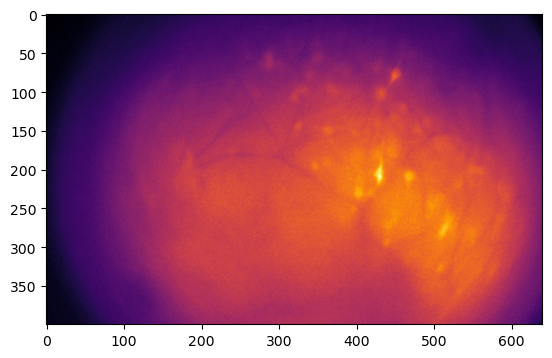

In [3]:
# show the 30th frame
plt.imshow(isxd_stack[30])

## Loading .tif files
The processing of movies read from `.isxd` files is the same as processing of movies read from `.tif` files. However, most of my processing has generally been done on spatially-bandpassed movies. This spatial bandpassing was done in IDPS, from which they were saved as `.tif` files. So, you will likely need to load those as well:

In [4]:
# load the bandpassed movie from a tif using imageio
movie_bandpassed = imageio.volread("../data/denoising_experiments/2022-10-14-07-48-47_video_bandpass.tif")

# this is also a numpy array of same shape as before
movie_bandpassed.shape

(80, 400, 640)

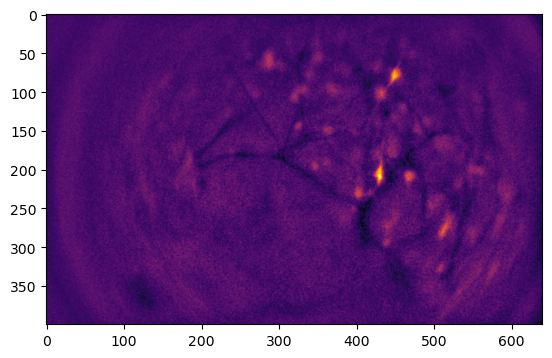

In [5]:
# show the 30th frame
plt.imshow(movie_bandpassed[30])

## Neural network deconvolution
We now may want to deconvolve this image. First, we want to load the neural network:

In [6]:
import preset_nn

# the model that you create has to match the saved weights
# the default created by instant_multiwienernet is the same as noisy5.
# However, you may want to use e.g. blurpools as per Zhang, 2019.
# In that case, you may want to use something like the commented-out line:
# model = preset_nn.instant_multiwienernet(pooling='averageblur')
model = preset_nn.instant_multiwienernet()

# replace this with the path to the model weights that you save
weights_path = "saved_models/multiwiener_nV3_probe_noisy5/model_weights"

model.load_weights(weights_path)

2023-04-27 14:46:58.670315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 14:46:58.844533: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 14:46:58.879330: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-27 14:46:59.804908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Now that we have created the neural network and loaded the weights, we want to actually do the deconvolution.

The neural network takes an input of shape `(num_frames, 800, 1280, 1)`, so we need to resize the image that we just loaded. Also, we need the pixel values to be between 0 and 1 so we must rescale those. The former (resizing) should be done with `cv2`. The latter (rescaling) should be done with `denoising`.

The output of the neural network is of shape `(num_frames, 800, 1280)`.

In theory, you could put multiple frames through. In practice, we run out of GPU memory doing this with more than two frames because the Multiwiener layer is just so huge. Even with two frames it sometimes works and sometimes not depending on what else is occupying the GPU, so I find it good practice to always only put one frame at a time through the neural network. Thus, we will only have one output frame and will take the 0th slice of the output in the first dimension.

2023-04-27 14:47:04.955850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2023-04-27 14:47:05.413479: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-27 14:47:05.625326: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-27 14:47:05.873467: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Text(0.5, 1.0, 'deconvolved frame')

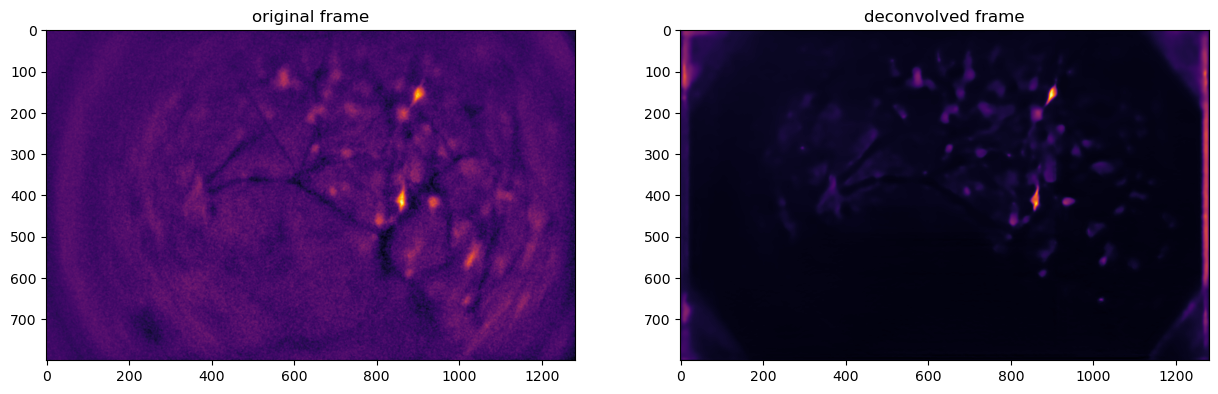

In [7]:
# rescale the whole movie to a 0-1 scale of pixel values
# we want to do this to the whole movie to keep all frames on the same scale.
scaled_movie = denoising.rescale_to_one(movie_bandpassed)

# arbitrarily pick one frame we will work with to make stuff run quickly
frame_ind = 30

# resize only one frame, since that's reasonably computationally-intensive
resized_frame = cv2.resize(scaled_movie[frame_ind], (1280, 800))

# actually call the neural network on that frame
# we want to reshape the resized frame to fit the arbitrary-framecount/arbitrary-depth input standard of the model
# and we want a 2D output, so we are only taking the first frame (out of, in this case, 1 frame)
deconvolved_frame = model(resized_frame.reshape((1,800,1280,1)))[0,:,:]

# plot both the input and the output to compare
fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(resized_frame)
axs[0].set_title("original frame")

axs[1].imshow(deconvolved_frame)
axs[1].set_title("deconvolved frame")

### Vessel deconvolution
This is a small extension beyond what was done above. To deconvolve vessels, simply invert the image:

Text(0.5, 1.0, 'deconvolved vessels')

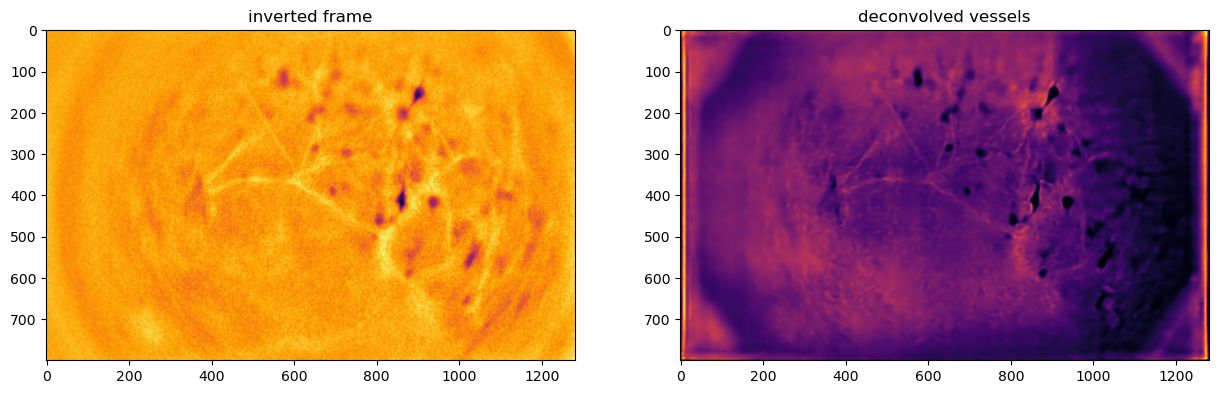

In [8]:
# invert the frame
# resized_frame is already on a 0-1 scale
inverted_frame = 1 - resized_frame

# passing the inverted frame through a neural network will bring out the vessels
vessel_frame = model(inverted_frame.reshape((1,800,1280,1)))[0,:,:]

# display the thing
fig, axs = plt.subplots(1,2,figsize=(15,15))

axs[0].imshow(inverted_frame)
axs[0].set_title("inverted frame")

axs[1].imshow(vessel_frame)
axs[1].set_title("deconvolved vessels")

### "Consolidated negatives"
To make the "consolidated negatives", I've simply been subtracting the deconvolved vessel image from the deconvolved cell image. This makes sense because the deconvolved vessel image has been inverted, and subtracting it will make the features that should be more negative than background that way again (namely vessels):

Text(0.5, 1.0, 'consolidated negative')

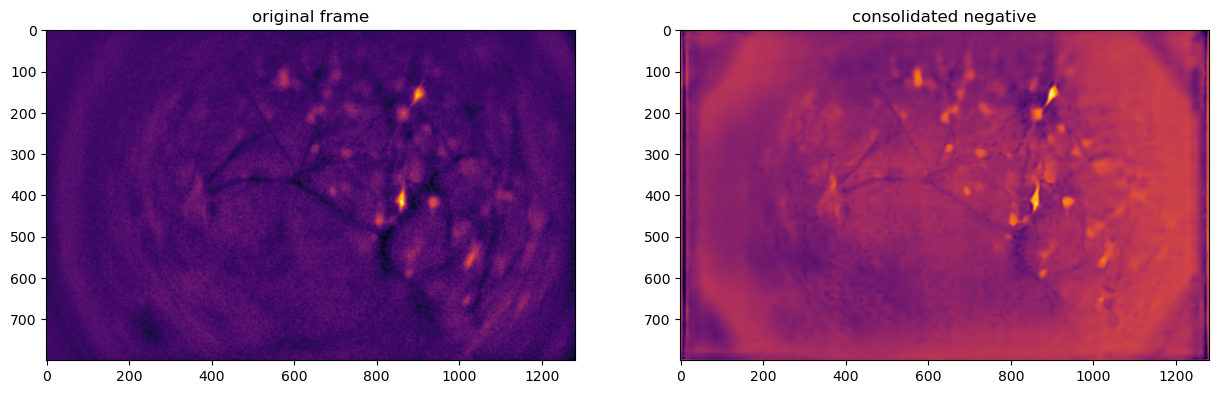

In [9]:
# deconvolved_frame is the image in which cells were deconvolved--from two code blocks ago.
# The vessel_frame is the image in which vessels were deconvolved--from the previous code block.
consolidated_negative = deconvolved_frame - vessel_frame
fig, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(resized_frame)
axs[0].set_title("original frame")
axs[1].imshow(consolidated_negative)
axs[1].set_title("consolidated negative")

## Denoising
I've also built a bit of a denoising and background-removing pipeline. This is all contained within the `denoising` library in `../common/`. Here, I'll demonstrate an example of this denoising, and the same thing passed through the MultiWienerNet

Text(0.5, 1.0, '30th frame, denoised after multiwienernet')

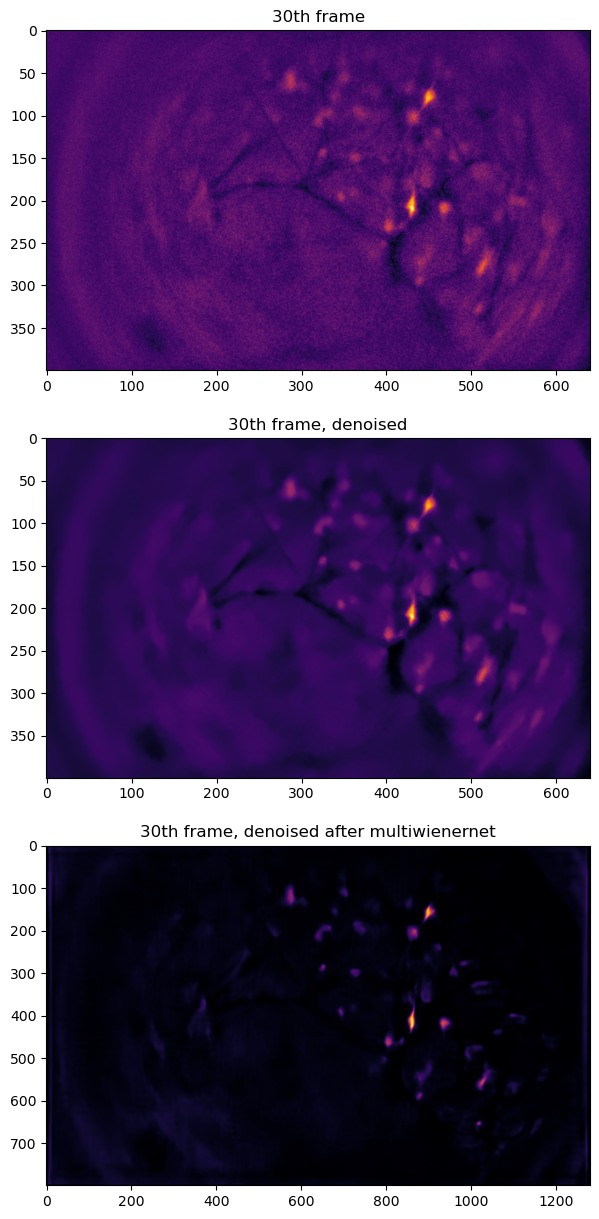

In [10]:
# take a background full of zeros for subtraction, since we don't actually want to subtract anything. 
# Otherwise, we could use a background that we know is inherent in the system or the microscope.
background = np.zeros((400,640))

# h is the h-parameter in NLM denoising
# num_images is the number of temporally-adjacent frames that we want to average to reduce noise.
# in this case, we only want to take the one frame
denoised_img = denoising.full_denoising(movie_bandpassed, frame_ind, background, h=8, num_images=1, denoising_method="NLM")

fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].imshow(movie_bandpassed[frame_ind])
axs[0].set_title(str(frame_ind) + "th frame")
axs[1].imshow(denoised_img)
axs[1].set_title(str(frame_ind) + "th frame, denoised")
axs[2].imshow((model(cv2.resize(denoised_img, (1280, 800)).reshape((1,800,1280,1)))[0,:,:]))
axs[2].set_title(str(frame_ind) + "th frame, denoised after multiwienernet")

## Saving a single image as a .tif
The next thing that I'll demonstrate is saving a single image as a `.tif`. For this, I'll save the consolidated negative.

In [11]:
# need to import tifffile to do this. It should already be in your environment from reproduce.yml
import tifffile

# next, you need to convert the pixels to uint16
# first, we want to scale the image between the smallest and largest possible values:
rescaled_cons_neg = denoising.rescale_to_one(consolidated_negative.numpy())*65535

# now, recast to uint16
cons_neg_uint = rescaled_cons_neg.astype(np.uint16)

# finally, save the image
tifffile.imsave("../data/frame_30_consolidated_negative.tif", cons_neg_uint)

/tmp/ipykernel_1881925/1717456005.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread("../data/frame_30_consolidated_negative.tif"))


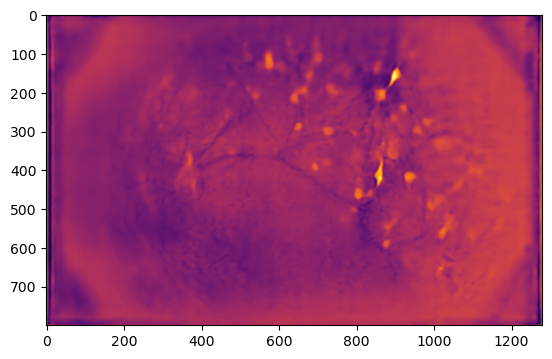

In [12]:
plt.imshow(imageio.imread("../data/frame_30_consolidated_negative.tif"))

## Deconvolving a whole movie
As hinted before, the way I would recommend deconvolving a whole movie is simply going frame by frame through it. The ideal way should be to deal with the whole movie at once, but that leads to OOM errors because of the size of the model and the GPU memory constraints.

In [13]:
# the array we want to store the output in
out_movie_arr = np.empty((movie_bandpassed.shape[0], 800, 1280))

# rescale the whole movie in one go, for both speed and to maintain scale across frames
rescaled_movie = denoising.rescale_to_one(out_movie_arr)

# iterate over the first ten frames to keep this notebook running quickly
for ind in range(10):
    # a more condensed version of what I wrote above
    out_movie_arr[ind] = model(cv2.resize(rescaled_movie[ind], (1280, 800)).reshape((1,800,1280,1)))[0,:,:]
    print("finished frame: " + str(ind))

/home/dshteinbok/MultiWienerNet/tensorflow/../common/denoising.py:27: RuntimeWarning: invalid value encountered in divide
  return img_shifted/np.max(img_shifted)


finished frame: 0
finished frame: 1
finished frame: 2
finished frame: 3
finished frame: 4
finished frame: 5
finished frame: 6
finished frame: 7
finished frame: 8
finished frame: 9


### Saving the movie
Next, I want to demonstrate saving the movie as a `.tif`. This procedure is the same as saving a single image to a `.tif`:

In [14]:
# rescale again to cover the full range of two bytes as uint
out_movie_arr_rescaled = denoising.rescale_to_one(out_movie_arr)*65535

# convert to uint16
out_movie_arr_uint = out_movie_arr_rescaled.astype(np.uint16)

# now, we actually want to save:
tifffile.imsave("consolidated_negative_bandpassed.tif", out_movie_arr_uint)